In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from caveclient import CAVEclient

In [2]:
bin_width = 0.05
step_size = 0.01
y_resolution = 4  # nm per voxel

In [3]:
labels = np.array([107000, 147000, 184000, 224000, 265000]) * y_resolution

In [4]:
datastack_name = "minnie65_phase3_v1"
client = CAVEclient(datastack_name)

In [5]:
nuclei = client.materialize.query_table("nucleus_detection_v0")

In [141]:
client.materialize.query_table("synapses_pni_2", limit=10)  # how do I get a random subset of the synapses?

,id,valid,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,size,pre_pt_position,post_pt_position,ctr_pt_position
0,436364548,t,111557550675251237,864691135535210226,111557550675261506,864691136553667234,5996,"[340172, 232656, 25740]","[340062, 232658, 25747]","[340114, 232650, 25740]"
1,264005708,t,97748988958188464,864691135198052729,97748988958185114,864691135468164178,3316,"[240120, 111772, 15417]","[240062, 111732, 15416]","[240082, 111736, 15418]"
2,77747869,t,82759416059344036,864691135460738390,82759484778815594,864691133764993492,3452,"[130774, 104106, 18944]","[130770, 104148, 18937]","[130782, 104124, 18941]"
3,39818114,t,79667040411348377,864691136744616420,79667040411334862,864691135373756233,3316,"[108550, 132626, 24933]","[108488, 132588, 24921]","[108520, 132652, 24925]"
4,277766212,t,98736694467232302,864691136711996278,98736694467246195,864691136108749752,556,"[246938, 130582, 19153]","[246876, 130522, 19160]","[246895, 130532, 19156]"
5,1859642,t,75236763794364737,864691135218523802,75236763794364603,864691135788393324,21364,"[75940, 154498, 19806]","[75940, 154392, 19807]","[75978, 154432, 19805]"
6,262972736,t,97676560039328671,864691136084921049,97676560039322997,864691133978942396,4572,"[239292, 96160, 26471]","[239312, 96174, 26463]","[239308, 96178, 26466]"
7,476492210,t,115358011878329621,864691135271878401,115358011878325109,864691135935487384,4740,"[367926, 236874, 19986]","[367908, 236986, 19982]","[367958, 236932, 19979]"
8,120866309,t,85661164616367570,864691136220010218,85661164616362790,864691133890235434,4740,"[152038, 227868, 17969]","[152086, 227878, 17957]","[152064, 227872, 17961]"
9,217229972,t,93678665632018955,864691134818608677,93749034376136266,864691135495737074,21392,"[210410, 194086, 15742]","[210486, 194006, 15732]","[210436, 194038, 15739]"


In [6]:
col_cells = client.materialize.query_table("allen_v1_column_types_v2")
exc_cells = col_cells.query("classification_system == 'aibs_coarse_excitatory'")
exc_cells = col_cells.query("classification_system == 'aibs_coarse_inhibitory'")
len(exc_cells), len(inh_cells)

(1185, 162)

In [16]:
auto_cells = client.materialize.query_table("allen_soma_coarse_cell_class_model_v1")

# bounding box of the proofread column we're interested in
bbox = np.array([[ 672444., 200000., 805320.], [ 772444., 1294000., 905320.]])  # nm
resolution = np.array([4., 4., 40.])
bbox /= resolution
def in_bbox(p):
    """ returns whether point is between the two points given by bbox"""
    lower, upper = bbox
    return lower[0] <= p[0] < upper[0] and lower[1] <= p[1] < upper[1] and lower[2] <= p[2] < upper[2]

auto_col_cells = auto_cells[auto_cells.pt_position.apply(in_bbox)]
auto_exc_cells = auto_col_cells.query("classification_system == 'aibs_coarse_excitatory'")
auto_inh_cells = auto_col_cells.query("classification_system == 'aibs_coarse_inhibitory'")

In [8]:
# cross sectional area to be layered
xarea = resolution[0] * resolution[2] * (bbox[1][0] - bbox[0][0]) * (bbox[1][2] - bbox[0][2]) / 1_000_000 ** 2

In [18]:
# min is pia border (L1) and max is white matter border (L6)
min_y = min(pt[1] * y_resolution / 1_000_000 for pt in auto_col_cells.pt_position)
max_y = max(pt[1] * y_resolution / 1_000_000 for pt in auto_col_cells.pt_position)
min_y, max_y

(0.358016, 1.086656)

In [10]:
exc_cells.cell_type.unique()

array(['6P', '5P_PT', '23P', '4P', '5P_IT', '5P_NP', 'Unsure', '6IT',
       '6CT'], dtype=object)

In [11]:
ctype_to_layer = {"23P": "23",
                 "4P": "4",
                 "5P_PT": "5",
                 "5P_IT": "5",
                 "5P_NP": "5",
                 "6P": "6",
                 "6CT": "6",
                 "6IT": "6"}

In [131]:
# TODO SPEEDUP
exc_soma_densities = []
inh_soma_densities = []
p_type = dict((t, []) for t in ["23", "4", "5", "6"])
avg_volumes = []  # todo of what cells?  measured in micrometers^3
bin_centers = []
curr_y = min_y
while curr_y < max_y:
    bin_centers.append(curr_y + step_size // 2)
    current_exc_cells = auto_exc_cells[[curr_y <= p[1] * y_resolution / 1_000_000 < curr_y + bin_width for p in auto_exc_cells.pt_position]]
    for t in p_type:
        p_type[t].append(0)
    for i in current_exc_cells.index:
        if current_exc_cells.loc[i].cell_type != "Unsure":
            p_type[ctype_to_layer[current_exc_cells.loc[i].cell_type]][-1] += 1 / len(current_exc_cells) if len(current_exc_cells) > 0 else np.nan
    exc_soma_densities.append(len(current_exc_cells))
    inh_soma_densities.append(sum(curr_y <= p[1] * y_resolution / 1_000_000 < curr_y + bin_width for p in auto_inh_cells.pt_position))
    these_nuclei = nuclei[list(curr_y <= p[1] * y_resolution / 1_000_000 < curr_y + step_size for p in nuclei.pt_position)]
    avg_volumes.append(these_nuclei.volume.mean())
    curr_y += step_size
bin_centers = np.array(bin_centers)
exc_soma_densities = np.array(exc_soma_densities, dtype=float) / (bin_width * xarea)  # per mm^3
inh_soma_densities = np.array(inh_soma_densities, dtype=float) / (bin_width * xarea)
avg_volumes = np.array(avg_volumes)
for t in p_type:
    p_type[t] = np.array(p_type[t])

L1: low soma density
L2: high soma density
L3: med soma density
L4: high soma density
L5: med soma density, large soma
L6: medhigh soma density

L1-L2	107000

L3-L4	147000
L4-L5	184000
L5-L6	224000
L6-WM	265000

In [ ]:
from scipy import fft

In [172]:
e_fft = fft.fft(exc_soma_densities)
e_fft[8:-8] = 0   # remove high frequency content (details/noise)
smooth_exc_densities = fft.ifft(e_fft)

C:\Users\ATMal\miniconda3\envs\ofs\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


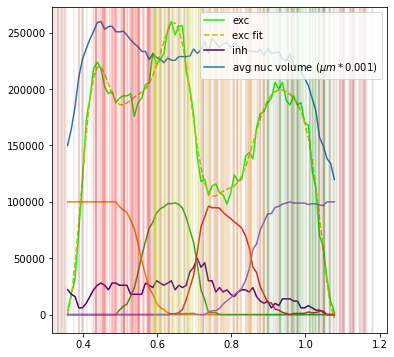

In [177]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(bin_centers, exc_soma_densities, c="lime", label="exc")
ax.plot(bin_centers, smooth_exc_densities, "--y", label="exc fit")
ax.plot(bin_centers, inh_soma_densities, c="indigo", label="inh")
ax.plot(bin_centers, avg_volumes * max(exc_soma_densities) / max(avg_volumes), label=f"avg nuc volume ($\mu m * {round(max(avg_volumes) / max(exc_soma_densities), 4)}$)")
for t in p_type:
    ax.plot(bin_centers, p_type[t] * 100_000)

cells_to_plot = col_cells
indices_to_plot = np.random.choice(cells_to_plot.index, 500)
for cell in indices_to_plot:
    if cells_to_plot.loc[cell].cell_type == "23P":
        ax.axvline(cells_to_plot.loc[cell].pt_position[1] * y_resolution / 1_000_000, color="red", alpha=0.1)

    if cells_to_plot.loc[cell].cell_type == "4P":
        ax.axvline(cells_to_plot.loc[cell].pt_position[1] * y_resolution / 1_000_000, color="y", alpha=0.1)

    if cells_to_plot.loc[cell].cell_type.startswith("5P"):
        ax.axvline(cells_to_plot.loc[cell].pt_position[1] * y_resolution / 1_000_000, color="orange", alpha=0.1)

    if cells_to_plot.loc[cell].cell_type in ["6P", "6IT", "6CT"]:
        ax.axvline(cells_to_plot.loc[cell].pt_position[1] * y_resolution / 1_000_000, color="green", alpha=0.1)

    if cells_to_plot.loc[cell].cell_type.startswith("Unsure"):
        ax.axvline(cells_to_plot.loc[cell].pt_position[1] * y_resolution / 1_000_000, color="brown", alpha=0.1)
        
# for lab in labels:
#     ax.axvline(lab, linestyle="--", color="k")
ax.legend()
plt.show()

# Boundary finding
Ideas:
Threshholds, except there is a weight to match these widths (L1-L2 boundary at 0.4mm, L2/3 0.18mm wide, L4 0.17mm wide

## Nuno's Find the halfway points between the local extrema (but what about 3/4?)
Use the fft-smoothed version of the data

In [ ]:
bounds = np.empty(labels.shape)

In [188]:
def find_local_extrema(x):
    """specifically for the task of layer segmentation."""
    assert x[1] > x[0]
    assert x[-2] > x[-1]
    maxima_idxs = []
    maxima = []
    minima_idxs = [0]
    minima = [x[0]]
    for i in range(1, len(x) - 1):
        if x[i-1] < x[i] and x[i] > x[i+1]:
            maxima_idxs.append(i)
            maxima.append(x[i])
        if x[i-1] > x[i] and x[i] < x[i+1]:
            minima_idxs.append(i)
            minima.append(x[i])
    minima_idxs.append(len(x) - 1)
    minima.append(x[-1])
    assert len(maxima_idxs) == 3
    assert len(minima_idxs) == 4
    return maxima_idxs, minima_idxs, maxima, minima

In [189]:
maxima_idxs, minima_idxs, maxima, minima = find_local_extrema(smooth_exc_densities)

In [191]:
thresh = (minima[0] + maxima[0]) /  2
for i in range(minima_idxs[0] + 1, maxima_idxs[0]):
    if exc_soma_densities[i] > thresh > exc_soma_densities[i - 1]:
        bounds[0] = bin_centers[i]
        
thresh = (minima[1] + maxima[1]) /  2  # NOTE: we skip one threshold (perhaps L2-L3 boundary?)
for i in range(minima_idxs[1] + 1, maxima_idxs[1]):
    if exc_soma_densities[i] > thresh > exc_soma_densities[i - 1]:
        bounds[1] = bin_centers[i]
        
thresh = (minima[2] + maxima[1]) /  2
for i in range(maxima_idxs[1] + 1, minima_idxs[2]):
    if exc_soma_densities[i] < thresh < exc_soma_densities[i - 1]:
        bounds[2] = bin_centers[i]
        
thresh = (minima[2] + maxima[2]) /  2
for i in range(minima_idxs[2] + 1, maxima_idxs[2]):
    if exc_soma_densities[i] > thresh > exc_soma_densities[i - 1]:
        bounds[3] = bin_centers[i]
        
thresh = (minima[3] + maxima[2]) /  2
for i in range(maxima_idxs[2] + 1, minima_idxs[3]):
    if exc_soma_densities[i] < thresh < exc_soma_densities[i - 1]:
        bounds[4] = bin_centers[i]

## Weighted combination of depth, excitatory density, and cell type
It turns out cell type was heavily determined by depth, so this method is not very good

In [29]:
bounds = np.empty(labels.shape)

In [81]:
def gaussian(x, center=0, size=1):
    """ gaussian with max=1"""
    return np.exp(-(x - center)**2 / (2*size**2))

def decreasing_mask(x):
    """ Finds the indices where x[i] > x[i-1], and returns a boolean array of the same shape.
    The first index of the result takes the same value as the second.
    """
    if len(x) < 2:
        return np.full(len(x), False)
    result = [x[i-1] > x[i] for i in range(1, len(x))]
    result = [result[0]] + result
    return np.array(result)


In [102]:
# L1-L2 boundary
depth = 0.4 # mm
exc_density_thresh = 150_000  # somas per micron depth (in a 0.100 x 0.100 mm area)
# the L1-L2 boundary is not going to be deeper than 0.7 mm
# and must be during increasing density portion
possible_idxs = np.nonzero((bin_centers < 0.7) \
                & ~decreasing_mask(exc_soma_densities))[0]  
quality = gaussian(exc_soma_densities[possible_idxs], center=exc_density_thresh, size=20_000) \
          * gaussian(bin_centers[possible_idxs], center=depth, size=0.08)
bounds[0] = bin_centers[possible_idxs[np.argmax(quality)]]

In [103]:
np.nonzero((bin_centers < 0.7) \
                & ~decreasing_mask(exc_soma_densities))[0]  

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 12, 14, 15, 16, 17, 19, 20, 21,
       22, 23, 25, 26, 27, 28, 30, 31], dtype=int64)

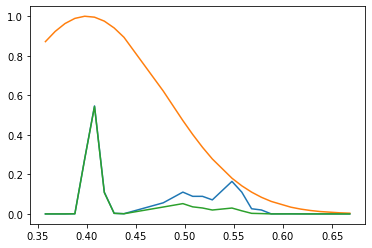

In [104]:
plt.plot(bin_centers[possible_idxs], gaussian(exc_soma_densities[possible_idxs], center=exc_density_thresh, size=20_000))
plt.plot(bin_centers[possible_idxs], gaussian(bin_centers[possible_idxs], center=depth, size=0.08))
plt.plot(bin_centers[possible_idxs], quality)

In [105]:
# L3-L4 boundary
depth = bounds[0] + 0.18
layer = "23"
# and must be during increasing density portion  (I know index 0 is messed up--it shouldn't matter)
possible_idxs = np.nonzero(decreasing_mask(p_type[layer]))[0]
quality = gaussian(p_type[layer][possible_idxs], center=0.5, size=0.1) \
          * gaussian(bin_centers[possible_idxs], center=depth, size=0.08)
bounds[1] = bin_centers[possible_idxs[np.argmax(quality)]]

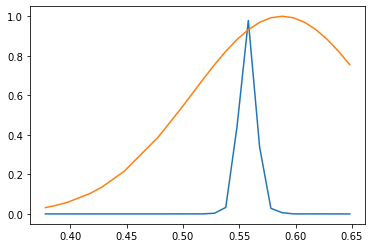

In [106]:
plt.plot(bin_centers[possible_idxs], gaussian(p_type[layer][possible_idxs], center=0.5, size=0.1))
plt.plot(bin_centers[possible_idxs], gaussian(bin_centers[possible_idxs], center=depth, size=0.08))
# plt.plot(bin_centers, decreasing_mask(p_type[layer]))

In [107]:
# L4-L5 boundary
depth = bounds[1] + 0.17
exc_density_cutoff = 170_000
layer = "4"
# and must be during increasing density portion  (I know index 0 is messed up--it shouldn't matter)
possible_idxs = np.nonzero(decreasing_mask(p_type[layer])
                          & decreasing_mask(exc_soma_densities))[0]
quality = gaussian(p_type[layer][possible_idxs], center=0.5, size=0.1) \
          * gaussian(bin_centers[possible_idxs], center=depth, size=0.08) \
          * gaussian(exc_soma_densities[possible_idxs], center=exc_density_cutoff, size=20_000)
bounds[2] = bin_centers[possible_idxs[np.argmax(quality)]]

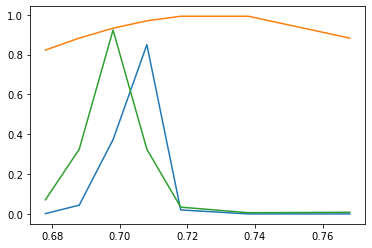

In [108]:
plt.plot(bin_centers[possible_idxs], gaussian(p_type[layer][possible_idxs], center=0.5, size=0.1))
plt.plot(bin_centers[possible_idxs], gaussian(bin_centers[possible_idxs], center=depth, size=0.08))
plt.plot(bin_centers[possible_idxs], gaussian(exc_soma_densities[possible_idxs], center=exc_density_cutoff, size=20_000))

In [111]:
# L5-L6 boundary
depth = bounds[2] + 0.15
exc_density_cutoff = 160_000
layer = "5"
# and must be during increasing density portion  (I know index 0 is messed up--it shouldn't matter)
possible_idxs = np.nonzero(decreasing_mask(p_type[layer])
                          & ~decreasing_mask(exc_soma_densities))[0]
quality = gaussian(p_type[layer][possible_idxs], center=0.5, size=0.1) \
          * gaussian(bin_centers[possible_idxs], center=depth, size=0.08) \
          * gaussian(exc_soma_densities[possible_idxs], center=exc_density_cutoff, size=20_000)
bounds[3] = bin_centers[possible_idxs[np.argmax(quality)]]

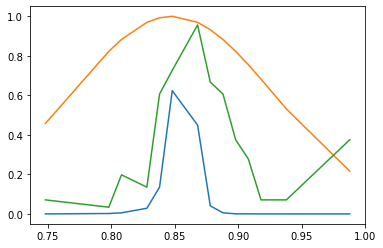

In [112]:
plt.plot(bin_centers[possible_idxs], gaussian(p_type[layer][possible_idxs], center=0.5, size=0.1))
plt.plot(bin_centers[possible_idxs], gaussian(bin_centers[possible_idxs], center=depth, size=0.08))
plt.plot(bin_centers[possible_idxs], gaussian(exc_soma_densities[possible_idxs], center=exc_density_cutoff, size=20_000))

In [123]:
# L6-WM boundary
depth = bounds[3] + 0.17
exc_density_cutoff = 130_000
# and must be during increasing density portion  (I know index 0 is messed up--it shouldn't matter)
possible_idxs = np.nonzero((bin_centers > 0.95) & decreasing_mask(exc_soma_densities))[0]
quality = gaussian(bin_centers[possible_idxs], center=depth, size=0.08) \
          * gaussian(exc_soma_densities[possible_idxs], center=exc_density_cutoff, size=20_000)
bounds[4] = bin_centers[possible_idxs[np.argmax(quality)]]

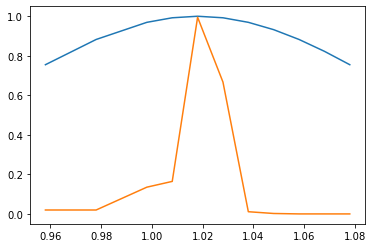

In [124]:
plt.plot(bin_centers[possible_idxs], gaussian(bin_centers[possible_idxs], center=depth, size=0.08))
plt.plot(bin_centers[possible_idxs], gaussian(exc_soma_densities[possible_idxs], center=exc_density_cutoff, size=20_000))
# plt.plot(bin_centers[possible_idxs], quality)

ValueError: cannot convert float NaN to integer

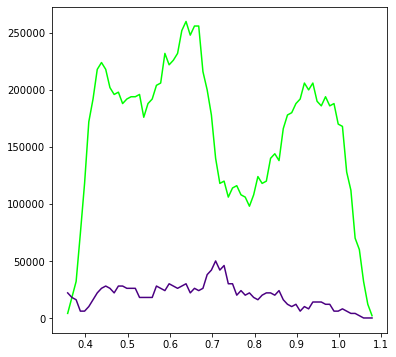

In [129]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(bin_centers, exc_soma_densities, c="lime", label="exc")
ax.plot(bin_centers, inh_soma_densities, c="indigo", label="inh")
ax.plot(bin_centers, avg_volumes * max(exc_soma_densities) / max(avg_volumes), label=f"avg nuc volume ($\mu m * {round(max(avg_volumes) / max(exc_soma_densities))}$)")
for t in p_type:
    ax.plot(bin_centers, p_type[t] * 100_000)

cells_to_plot = col_cells
indices_to_plot = np.random.choice(cells_to_plot.index, 500)
for cell in indices_to_plot:
    if cells_to_plot.loc[cell].cell_type == "23P":
        ax.axvline(cells_to_plot.loc[cell].pt_position[1] * y_resolution / 1_000_000, color="red", alpha=0.1)

    if cells_to_plot.loc[cell].cell_type == "4P":
        ax.axvline(cells_to_plot.loc[cell].pt_position[1] * y_resolution / 1_000_000, color="y", alpha=0.1)

    if cells_to_plot.loc[cell].cell_type.startswith("5P"):
        ax.axvline(cells_to_plot.loc[cell].pt_position[1] * y_resolution / 1_000_000, color="orange", alpha=0.1)

    if cells_to_plot.loc[cell].cell_type in ["6P", "6IT", "6CT"]:
        ax.axvline(cells_to_plot.loc[cell].pt_position[1] * y_resolution / 1_000_000, color="green", alpha=0.1)

    if cells_to_plot.loc[cell].cell_type.startswith("Unsure"):
        ax.axvline(cells_to_plot.loc[cell].pt_position[1] * y_resolution / 1_000_000, color="brown", alpha=0.1)
        
for bound in bounds:
    ax.axvline(bound, linestyle="--", color="k")
ax.legend()
plt.show()

In [128]:
exc_soma_densities

array([  4000.,  18000.,  32000.,  74000., 118000., 172000., 192000.,
       218000., 224000., 218000., 202000., 196000., 198000., 188000.,
       192000., 194000., 194000., 196000., 176000., 188000., 192000.,
       204000., 206000., 232000., 222000., 226000., 232000., 252000.,
       260000., 248000., 256000., 256000., 216000., 200000., 178000.,
       140000., 118000., 120000., 106000., 114000., 116000., 108000.,
       106000.,  98000., 108000., 124000., 118000., 120000., 140000.,
       144000., 138000., 166000., 178000., 180000., 188000., 192000.,
       206000., 200000., 206000., 190000., 186000., 194000., 186000.,
       188000., 170000., 168000., 128000., 112000.,  70000.,  60000.,
        32000.,  12000.,   2000.])

In [126]:
sum(auto_cells.cell_type == "BC")

3009

No handles with labels found to put in legend.


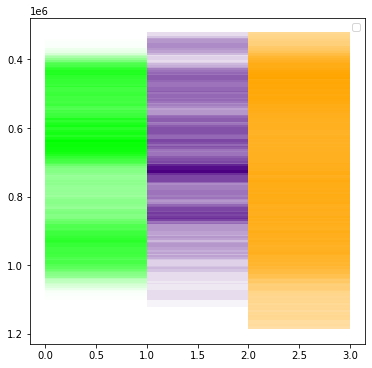

In [113]:
# todo fill with alpha = density
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
for i in range(len(bin_centers)):
        bin_start, bin_end = bin_centers[i] - step_size // 2, bin_centers[i] + step_size // 2
        ax.fill_between([0, 1], [bin_start]*2, [bin_end]*2, alpha=exc_soma_densities[i] / max(exc_soma_densities), color="lime", edgecolor=None)
        ax.fill_between([1, 2], [bin_start]*2, [bin_end]*2, alpha=inh_soma_densities[i] / max(inh_soma_densities), color="indigo", edgecolor=None)
        ax.fill_between([2, 3], [bin_start]*2, [bin_end]*2, alpha=avg_volumes[i] / max(avg_volumes), color="orange", edgecolor=None)
    
ax.invert_yaxis()
ax.legend()
plt.show()